<a href="https://colab.research.google.com/github/ketankishore27/TensorFlow/blob/master/Image_Classification_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   119k      0 --:--:-- --:--:-- --:--:--  119k
OK


In [0]:
!apt-get update & apt-get install tensorflow-model-server

Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorf

In [0]:
!pip install tensorflow-gpu==1.13.1

In [0]:
!pip install requests

In [0]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import random
import requests

from tensorflow.keras.datasets import cifar10
%matplotlib inline

**Loading the data**

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

**Scaling the data**

In [0]:
X_train, X_test = X_train/255, X_test/255

**Defining the Model**

In [0]:
model = tf.keras.models.Sequential()

In [0]:
model.add(tf.keras.layers.Conv2D(input_shape = [32, 32, 3], filters = 32, activation = 'relu', padding = 'same', kernel_size = 3))
model.add(tf.keras.layers.Conv2D(kernel_size = 3, filters = 32, activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides= 2, padding = 'valid'))
model.add(tf.keras.layers.Conv2D(kernel_size = 3, filters = 64, activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.Conv2D(kernel_size = 3, filters = 64, activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 10, activation = 'softmax'))
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

In [0]:
model.fit(X_train, y_train, epochs = 10, batch_size = 128)

Epoch 1/10
50000/50000 [==============================] - 11s 226us/sample - loss: 1.4566 - sparse_categorical_accuracy: 0.4711
Epoch 2/10
50000/50000 [==============================] - 11s 218us/sample - loss: 1.0308 - sparse_categorical_accuracy: 0.6373
Epoch 3/10
50000/50000 [==============================] - 11s 219us/sample - loss: 0.8564 - sparse_categorical_accuracy: 0.7015
Epoch 4/10
50000/50000 [==============================] - 11s 219us/sample - loss: 0.7363 - sparse_categorical_accuracy: 0.7435
Epoch 5/10
50000/50000 [==============================] - 11s 218us/sample - loss: 0.6469 - sparse_categorical_accuracy: 0.7738
Epoch 6/10
50000/50000 [==============================] - 11s 216us/sample - loss: 0.5613 - sparse_categorical_accuracy: 0.8035
Epoch 7/10
50000/50000 [==============================] - 11s 219us/sample - loss: 0.4818 - sparse_categorical_accuracy: 0.8326
Epoch 8/10
50000/50000 [==============================] - 11s 217us/sample - loss: 0.4129 - sparse_categ

In [0]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 143us/sample - loss: 0.9102 - sparse_categorical_accuracy: 0.7488


**Creating the Directory for model**

In [0]:
MODEL_DIR = 'model/'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))

In [0]:
if os.path.isdir(export_path):
  !rm -r {export_path}

In [0]:
tf.saved_model.simple_save(session = tf.keras.backend.get_session(), export_dir = export_path, inputs = {'input_image': model.input}, outputs = {t.name: t for t in model.outputs})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


In [0]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

**Running the Tensorflow Serving API**

In [0]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8502 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 3 in a separate thread.


In [0]:
!tail server.log

2019-10-02 18:41:40.559623: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-10-02 18:41:40.565594: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-10-02 18:41:40.595392: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-10-02 18:41:40.667586: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 114607 microseconds.
2019-10-02 18:41:40.667649: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:103] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2019-10-02 18:41:40.667730: I tensorflow_serving/core/loader_harness.cc:86] Successfully loaded servable version {name: cifar10 version: 1}
2019-10-02 18:41:40.669205: I tensorflow_serving

In [0]:
random_image = random.randint(0, len(X_test))

In [0]:
data =json.dumps({'signature_name': 'serving_default', 
                 'instances': [X_test[random_image].tolist()]})

In [0]:
headers = {'content_type' : 'application/json'}

In [0]:
json_response = requests.post(url = 'http://localhost:8501/v1/models/cifar10:predict', data = data, headers = headers)
#json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data=data, headers=headers)

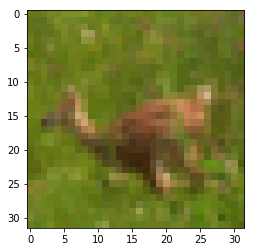

In [0]:
plt.imshow(X_test[random_image])

In [0]:
prediction = json.loads(json_response.text)['predictions']

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
class_names[np.argmax(prediction[0])]

'deer'